# Baselines & Bert

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.special import softmax
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer,  \
CountVectorizer
from sklearn.model_selection import train_test_split, KFold,  \
StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
accuracy_score, roc_auc_score, f1_score, auc
import evaluate
from datasets import load_metric

from get_metrics import get_metrics_classification, check_overfitting
from vectorizataion import DenseCountfVectorizer, DenseTfidfVectorizer, \
mean_vectorizer, TfIdfSVDTransformer
import evaluate

import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgbm
from catboost import CatBoostClassifier
import catboost
from catboost import Pool

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, \
RandomSampler, SequentialSampler

import tensorflow as tf
import keras

from transformers import BertTokenizer, BertForSequenceClassification,  \
BertConfig, get_linear_schedule_with_warmup, TextClassificationPipeline,  \
Trainer, AutoTokenizer, TrainingArguments

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import shap

from tqdm import tqdm_notebook
from tqdm.auto import tqdm

from typing import List, Tuple

import os
import warnings
from warnings import simplefilter

warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 10
MAX_WORDS = 5000

В данной работе решается задача определения тональности отзывов (позитив/негатив) клиентов онлайн-магазина "Озон".



Источник отзывов: otzovik.ru

В работе использованы следующие способы представления текста:
- Bag of Words
- TF-IDF(Term Frequency-Inverse Document Frequency)
- LSA (Latent Semantic Analysis)
- Word2Vec

c применением алгоритмов классификации классического ML.

Также была использована предобученная модель-трансформер BERT для анализа семантики отзывов и их классификации.

In [2]:
def plot_confusion_matrices(y_train: pd.Series,
                            y_test: pd.Series,
                            y_pred: pd.Series,
                            y_pred_train: pd.Series,
                            name: str) -> None:
    
    """
    Визуализация матрицы ошибок на обучающих и тестовых данных
    Параметры:
    - y_train, y_test: метки классов.
    - y_pred, y_pred_train: предсказанные метки классов на тестовом 
    и обучащем наборе, соответсвенно.
           
    """
    
    # Вычисление матрицы ошибок
    cm_test = confusion_matrix(y_test, y_pred)
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    # Вывод изображения матриц
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    
    disp_test.plot(ax=ax[0])
    ax[0].title.set_text(name + ' test')
    disp_train.plot(ax=ax[1])
    ax[1].title.set_text(name + ' train')

    
def make_classification(vectorizer,
                        classifier,
                        X_train: np.ndarray,
                        y_train: pd.Series,
                        X_test: np.ndarray,
                        X_val:np.ndarray = None,
                        y_val:pd.Series = None) -> tuple:
    """
    Функция, выполняющая классификацию с заданным векторизатором и классификатором,
    обучения его на обучающих данных и выполнения предсказаний на тестовых данных 
    и обучающих данных (для оценки переобучения).
    
    Параметры:
    vectorizer: объект векторизатора текста 
    classifier: объект классификатора 
    X_train: обучающие данные
    y_train: метки классов для обучающих данных
    X_test: тестовые данные
    X_val: валидационные данные
    y_val: метки на валидационных данных
    
    Возвращает:
    y_pred: предсказанные метки классов для тестовых данных
    y_pred_proba: вероятности классов для тестовых данных
    y_pred_train: предсказанные метки классов для обучахщих данных 
        для оценки переобучения
    pipe: пайплайн с обученным классификатором, для оценки метрик 
        на тренировочных данных с алгоритмами, не требующими валидационных 
        данных для бейзлайна
    classifier: классификатор, в случае если предсказание выполнялось 
        LightGBM/CatBoost
    """
    
    if classifier.__class__.__name__ in ['LGBMClassifier',
                                         'CatBoostClassifier']:
        
        # Векторизация данных
        vectorizer = vectorizer
        X_train_tf = vectorizer.fit_transform(X_train)
        X_val_tf = vectorizer.transform(X_val)
        X_test_tf = vectorizer.transform(X_test)
        
        # Обучение классификатора LGBMCLassifier
        if classifier.__class__.__name__ == 'LGBMClassifier':
            
            classifier.fit(X_train_tf, 
                           y_train, 
                           eval_metric='f1', 
                           eval_set=[(X_val_tf, y_val)], 
                           callbacks=[lgbm.early_stopping(stopping_rounds=100)])


    
        else:
            # Обучение классификатора CatBoostClassifier
            classifier.fit(
                           Pool(data=X_train_tf, 
                                label=y_train), 
                           eval_set=Pool(data=X_val_tf, 
                                         label=y_val), 
                           early_stopping_rounds=100,
                           verbose=0
                           )
            
        # Предсказание на тестовых данных
        y_pred = classifier.predict(X_test_tf)
        y_pred_proba = classifier.predict_proba(X_test_tf)
        
        # Предсказание на обучащих данных для оценки переобучения
        y_pred_train = classifier.predict(X_train_tf)
        y_pred_proba_train = classifier.predict_proba(X_train_tf)
        
        check_overfitting(classifier, X_train_tf, y_train, 
                          X_test_tf,  y_test, f1_score)
        
    else:   
        # Создание пайплайна для всех остальных бейзлайнов классификторов, 
        # не требующих валидации
        
        pipe = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])

        # Обучение pipeline на обучающих данных
        pipe.fit(X_train, y_train)

        # Предсказание на тестовых данных
        y_pred = pipe.predict(X_test)
        y_pred_proba = pipe.predict_proba(X_test)
        
        # Предсказание на обучащих данных 
        y_pred_train = pipe.predict(X_train)
        y_pred_proba_train = pipe.predict_proba(X_train)
        
        check_overfitting(pipe, X_train, y_train, 
                          X_test, y_test, metric_fun=f1_score)
        
    return y_pred, y_pred_proba, y_pred_train


def tsne_plot_similar_words(title: str, 
                            labels: List[str], 
                            embedding_clusters: List[np.ndarray], 
                            word_clusters: List[List[str]], 
                            alpha: float, 
                            filename: str = None, 
                            font_size: int = 8) -> None:
    """
    Создает график t-SNE для визуализации кластеров слов.
    
    Параметры:
        title: Заголовок графика.
        labels: Список меток для каждого кластера.
        embedding_clusters: Список массивов вложений для каждого кластера.
        word_clusters: Список списков слов для каждого кластера.
        alpha: Прозрачность точек на графике.
               
    """
    plt.figure(figsize=(15, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    
    # Построение точек на графике для каждого кластера
    for label, embeddings, words, color in zip(labels, 
                                               embedding_clusters, 
                                               word_clusters, 
                                               colors):
        
        plt.scatter(embeddings[:, 0], 
                    embeddings[:, 1], 
                    c=color, 
                    alpha=alpha, 
                    label=label)
        
        # Добавление аннотаций для каждой точки
        for i, word in enumerate(words):
            plt.text(embeddings[i, 0], 
                     embeddings[i, 1], 
                     f"{word} ({i})", 
                     alpha=alpha, 
                     fontsize=8,
                     ha='right', 
                     va='bottom', 
                     rotation=0)
    
    plt.legend(loc='best')
    plt.title(title)
    plt.grid(True)
    plt.show()
   

In [3]:
df = pd.read_csv('PreprocessData_v_1.1.csv')
df = df.drop(columns='Unnamed: 0')
df.head()

,reviewText,Tokens,Tokens_stop,Sentences,target
0,впервые я взяла рассрочку никогда ничего не бр...,впервые взять рассрочка брать доверие компания...,впервые я взять рассрочка никогда ничего не бр...,"[['впервые', 'я', 'взять', 'рассрочка', 'никог...",0
1,"только что увидела дешевый флэш накопитель , о...",увидеть дешёвый флэш накопитель оплатить потре...,только что увидеть дешёвый флэш накопитель опл...,"[['только', 'что', 'увидеть', 'дешёвый', 'флэш...",0
2,с данным интернет магазином я познакомился год...,данные интернет магазин познакомиться год наве...,с данные интернет магазин я познакомиться год ...,"[['с', 'данные', 'интернет', 'магазин', 'я', '...",1
3,"наша жизнь не стоит на месте . время идет , и ...",наш жизнь стоить место время идти меняться мен...,наш жизнь не стоить на место время идти и всё ...,"[['наш', 'жизнь', 'не', 'стоить', 'на', 'место...",1
4,интернет магазин . . этот интернет магазин зна...,интернет магазин интернет магазин знак очень д...,интернет магазин этот интернет магазин знак я ...,"[['интернет', 'магазин'], ['этот', 'интернет',...",1


Описание датасета:

reviewText - отзывы после проведения первоначальной обработки \
Tokens - токены (леммы слов), составляющие отзывы, без учета стоп-слов \
Tokens_stop - токены (леммы слов), составляющие отзывы, с учетом стоп-слов \
Sentences - текст отзывов, разбитый на предложения с применением лемматизации \
target - целевая переменная, "1" - отзыв позитивный, "0" - отзыв негативный 

In [4]:
print(f'Количество отзывов в датасете {df.shape[0]}')

Количество отзывов в датасете 14792


Для представления отзывов в формате мешка слов и TF-IDF будем использовать токены без учета стоп-слов, основываясь на том
что отзывы объемные по количеству слов и отсуствие стоп-слов типа 'не' не скажется на точности классификации (проверял оба варианта разница в метриках минимальная). 

С учетом дисбаланса классов в качетсве целевой метрики будем оценивать гармоническое среднее F1.

In [5]:
# Разбиение данных на тренировочные/тестовые с сохранением стратификации
X = np.array(df.Tokens)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=RAND)

## Bag of Words


Bag of Words (Мешок слов) - это метод представления текста, который преобразует каждый документ в вектор, 
содержащий частоту встречаемости каждого слова из словаря.

In [165]:
# Создание мешка слов и матрицы терм-документ, в словаре используются 5000 слов

cv_vectorizer = CountVectorizer(max_features=MAX_WORDS)
cv_matrix = cv_vectorizer.fit_transform(df['Tokens'])
cv_array = cv_matrix.toarray()
cols = cv_vectorizer.get_feature_names_out()

cv_display = pd.DataFrame(cv_array, columns=cols)
cv_display

,абсолютно,абсолютный,абсурд,аванс,август,авиабилет,авить,авось,авто,автомат,...,якобы,январь,яндекс,яркий,ясно,ясный,ячейка,ящик,ёлка,ёмкость
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**BOW + NaiveBayes**

In [166]:
# Обучение и предсказание модели
y_pred, pred_proba, y_pred_tr = \
    make_classification(CountVectorizer(max_features=MAX_WORDS),
                        BernoulliNB(), X_train, y_train, X_test)

# Вывод метрик
metrics = pd.concat([get_metrics_classification(y_test, 
                                                y_pred,
                                                pred_proba,
                                                'BOW NaiveBayes test')])


metrics.set_index('model')

f1_score train: 0.863
f1_score test: 0.858
delta = 0.6 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.16944


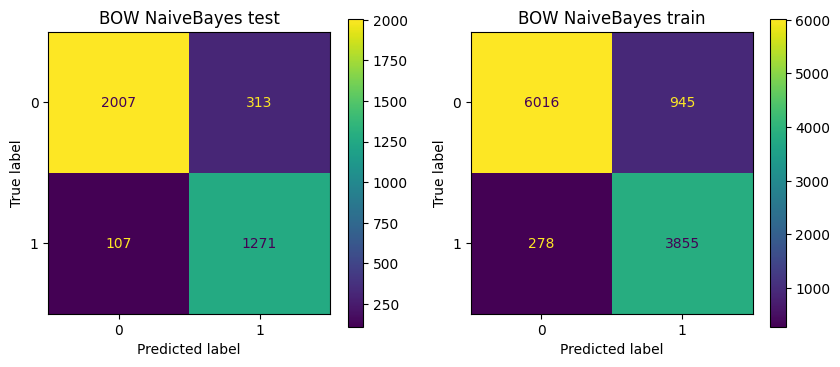

In [167]:
plot_confusion_matrices(y_train, 
                        y_test, 
                        y_pred, 
                        y_pred_tr, 
                        name='BOW NaiveBayes')

Даже такой слабый классификатор как наивный Байес показывает очень хорошие метрики

**BOW + LogisticRegression**

In [169]:
y_pred, pred_proba, y_pred_tr = make_classification(
    DenseCountfVectorizer(max_features=MAX_WORDS),
    LogisticRegression(class_weight="balanced", random_state=RAND),
    X_train,
    y_train,
    X_test)

metrics = pd.concat([
    metrics,
    get_metrics_classification(y_test, 
                               y_pred, 
                               pred_proba, 
                               "BOW Logistic_regression test")
                    ])


metrics.set_index('model')

f1_score train: 0.980
f1_score test: 0.880
delta = 11.5 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.16944
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.31125


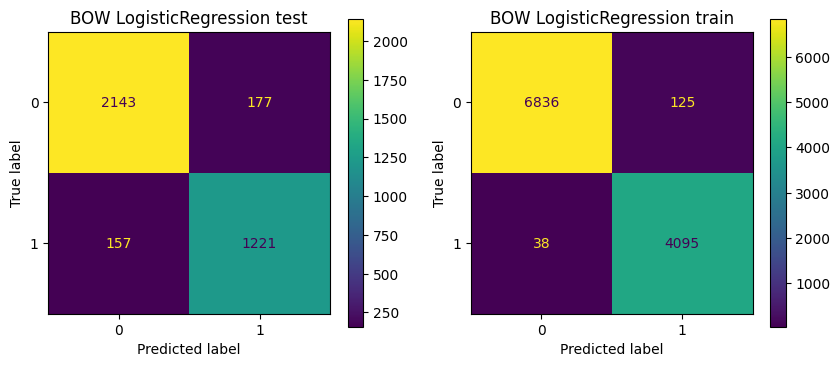

In [170]:
plot_confusion_matrices(y_train, 
                        y_test, 
                        y_pred, 
                        y_pred_tr, 
                        name='BOW LogisticRegression')

Логистическая регрессия с использованием мешка слов показала лучшие метрики на тестовых данных, 
однако имеет место переобучение.

## TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) - метод представления текста, который учитывает важность слова в конкретном документе и в контексте всей коллекции документов. Он вычисляет для каждого слова вес, который равен произведению частоты его встречаемости в документе (TF) и обратной частоты его встречаемости во всех документах (IDF). Этот метод позволяет выделить наиболее информативные слова, отличающие один документ от других, и учитывает их значимость при построении признакового пространства.

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_WORDS)

# Создание матрицы TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Tokens'])
tfidf_array = tfidf_matrix.toarray()
cols = tfidf_vectorizer.get_feature_names_out()

# ТF-IDF матрица "документ-терм"
tfidf_display = pd.DataFrame(tfidf_array, columns=cols)
tfidf_display

,абсолютно,абсолютный,абсурд,аванс,август,авиабилет,авить,авось,авто,автомат,...,якобы,январь,яндекс,яркий,ясно,ясный,ячейка,ящик,ёлка,ёмкость
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137606,...,0.0,0.0,0.105913,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.137345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.094545,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14787,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
14788,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
14789,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
14790,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.078912,0.0,0.0


**TF-IDF + LogisticRegression**

In [182]:
y_pred, pred_proba, y_pred_tr = make_classification(   \
                                                    
    DenseTfidfVectorizer(max_features=MAX_WORDS),
    LogisticRegression(class_weight='balanced', 
                       random_state=RAND),
    X_train,
    y_train,
    X_test

)



metrics = pd.concat([
    
    metrics, 
    get_metrics_classification(y_test, 
                               y_pred, 
                               pred_proba, 
                               'TF-IDF LogisticRegression test'
                               )
                     ])

metrics.set_index('model')

f1_score train: 0.920
f1_score test: 0.903
delta = 1.9 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.16944
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.31125
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.22595
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.22595


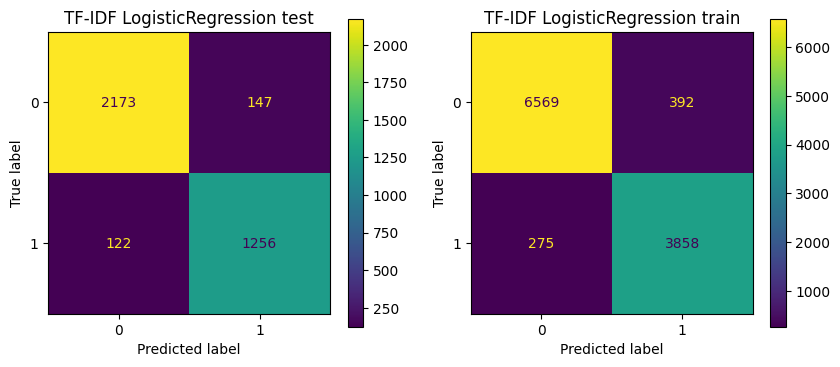

In [183]:
plot_confusion_matrices(y_train, 
                        y_test, 
                        y_pred, 
                        y_pred_tr, 
                        'TF-IDF LogisticRegression')

Логистическая регрессия c TF-IDF показала лучшие метрики, и главное, стала более устойчивая к переобучению

Посмотрим с помощью библиотеки shap вклад слов в тональность отзыва на примере модели логистической регрессии

In [175]:
X_train_vec = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_vec = tfidf_vectorizer.transform(X_test).toarray()
feat_names = tfidf_vectorizer.get_feature_names_out()

lr = LogisticRegression(class_weight='balanced', 
                        random_state=RAND)

lr.fit(X_train_vec, y_train)

explainer = shap.Explainer(
    lr, 
    X_train_vec, 
    feature_names=feat_names
)

shap_values = explainer(X_test_vec)

Возьмем положительный отзыв

In [176]:
print(X_test[23])

отличный интернет магазин наверное самый хороший существующий очень нравиться немой отличие другой сервис товар упаковать я случаться такой товар приходить сломать поцарапать кто ранний использовать лично доверять хотя товар бывать дорогой другой маркетплейс возможность найти товар скидка просто договориться скидка продавец ассортимент огромный начинать мелочь заканчивать крупный техника заказывать ванна прийти срок упаковать адекватный доставка продавец общительный отвечать мой вопрос также заказывать продукт питание корм собака сколько заказывать срок годность продукт хороший это самый хороший маркетплейс существующий данный период время заказывать быть заказывать именно


In [177]:
lr.predict(X_test_vec)[23]

1

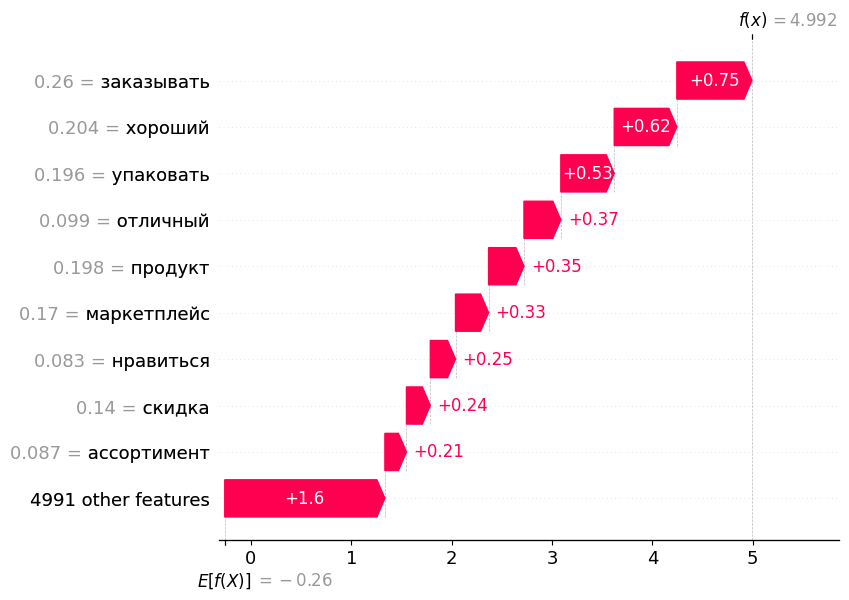

In [178]:
shap.plots.waterfall(shap_values[23], max_display=10)


Негативный отзыв

In [179]:
lr.predict(X_test_vec)[555]

0

In [180]:
print(X_test[555])

вместо доставка адрес заказ оставить склад деловой линия мочь получить поскольку продавец передать мой деньга доставка указать неверный телефон получение код выдача почему вообще должный ездить товар оплатить доставка дом подозревать никакой товар просто существовать озон бесконечно отправлять деловой линия доставить отдать озон игнорировать требование вернуть деньга доставка товар серь зный покупать сборище лохотронщик


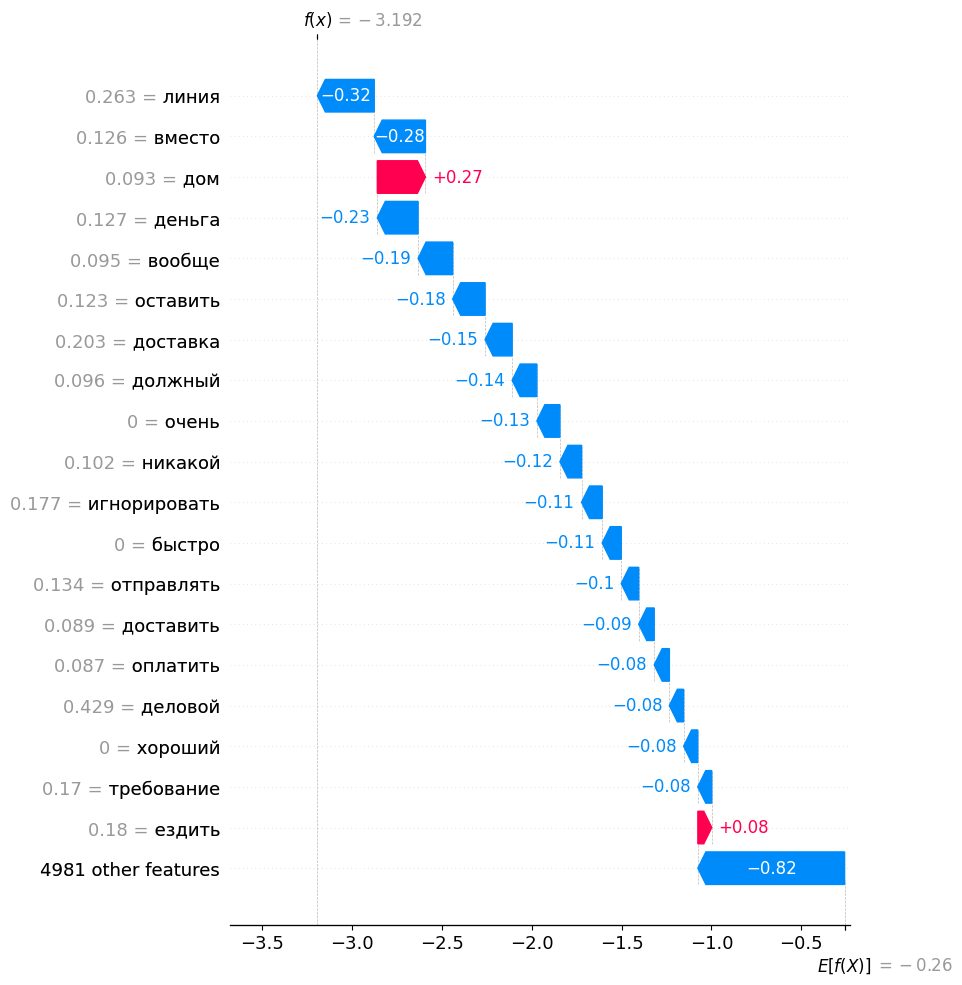

In [181]:
shap.plots.waterfall(shap_values[555], max_display=20)

**TF-IDF + RandomForest**

In [185]:
y_pred, pred_proba, y_pred_tr = make_classification(   \
                                                    
    TfidfVectorizer(max_features=MAX_WORDS), 
    RandomForestClassifier(class_weight='balanced', 
                           random_state=RAND), 
    X_train,
    y_train,
    X_test
)

metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'TF-IDF RandomForest test')
    
                    ])

metrics.set_index('model')

f1_score train: 1.000
f1_score test: 0.885
delta = 13.0 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521


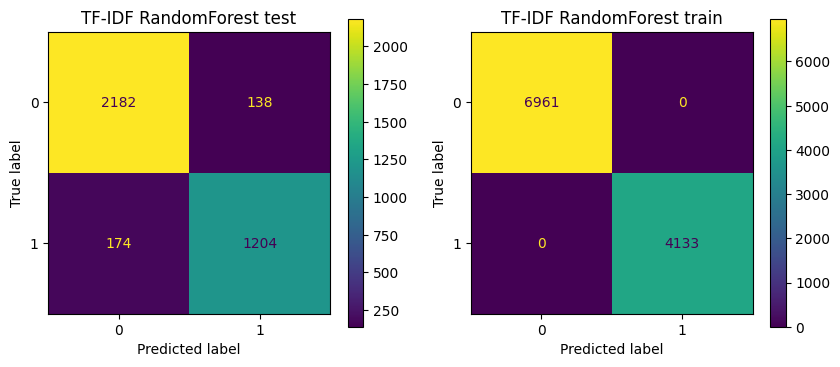

In [186]:
plot_confusion_matrices(y_train, 
                        y_test, 
                        y_pred, 
                        y_pred_tr, 
                        'TF-IDF RandomForest')

Бейзлайн случайного леса сильно переобучается.

In [188]:
# Разбиение данных на тренировочные/валидационные с сохранением стратификации для использования в бустингах

X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=RAND
)

In [189]:
# Вычисление ratio
dtrain = xgb.DMatrix(TfidfVectorizer(max_features=MAX_WORDS). \
                     fit_transform(X_train_), label=y_train_)

train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
ratio

1.6840307429547396

**TF-IDF + LGBMClassifier**

In [190]:
y_pred, pred_proba, y_pred_tr = make_classification(    \
                                                    
    TfidfVectorizer(max_features=MAX_WORDS),
    LGBMClassifier(class_weight='balanced',
                   random_state=RAND,
                   verbose=0),
    X_train_,
    y_train_,
    X_test,
    X_val,
    y_val
)

metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'TF-IDF LGBM test')
    
                    ])

metrics.set_index('model')

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.25334
f1_score train: 0.971
f1_score test: 0.893
delta = 8.8 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233


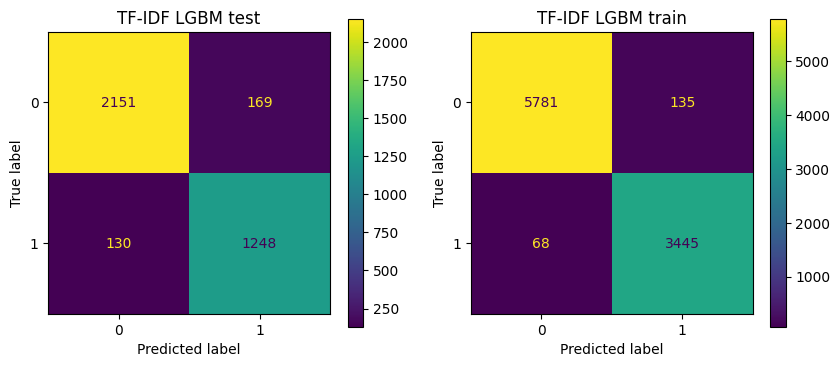

In [191]:
plot_confusion_matrices(y_train_, 
                        y_test, 
                        y_pred, 
                        y_pred_tr, 
                        'TF-IDF LGBM')

Хорошие метрики на тестовых данных, однако, устойчивость модели на грани.

**TF-IDF + CatBoost**

In [192]:
y_pred, pred_proba, y_pred_tr = make_classification(   \
    
    TfidfVectorizer(max_features=MAX_WORDS),
    CatBoostClassifier(scale_pos_weight=ratio,
                       random_state=RAND,
                       eval_metric="F1"),
    X_train_,
    y_train_,
    X_test,
    X_val,
    y_val
                                                    
)

metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'TF-IDF CatBoost test')
    
                    ])
metrics.set_index('model')

f1_score train: 0.912
f1_score test: 0.885
delta = 3.0 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549


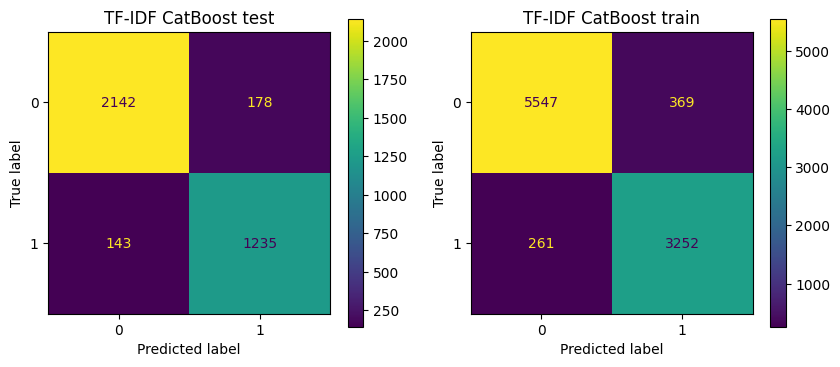

In [193]:
plot_confusion_matrices(y_train_, 
                        y_test, 
                        y_pred, 
                        y_pred_tr,
                        'TF-IDF CatBoost')

Результаты на тестовых данных схожи с LigthGBM, однако устойчивость модели ощутимо лучше.

In [194]:
metrics.reset_index(drop=True)   \
    .style.highlight_max(color='lightblue')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
1,BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
2,TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
3,TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
4,TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
5,TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
6,TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549


Бейзлайн логистической регрессии справляется лучше чем бустинги, лучшие метрики на тестовых данных и устойчивость к переобучению.

## LSA

LSA (Latent Semantic Analysis) - это метод анализа текста, который использует сингулярное разложение матрицы для снижения размерности признакового пространства и выявления латентных семантических признаков. Он позволяет выделить семантически связанные темы или концепции, учитывая сходство между словами и их контекстом.

В качестве исходных векторов будем использовать не мешок слов, а TF-IDF, снижение размерности обеспечит сигнулярное разложение матрицы SVD. TruncatedSVD в отличие от PCA не предоставляет возможность в параметре n_components задать долю сохраняемой информации (дисперсии), поэтому оценим сначала долю сохраняемой дисперсии для различного числа измерений.

  0%|          | 0/25 [00:00<?, ?it/s]

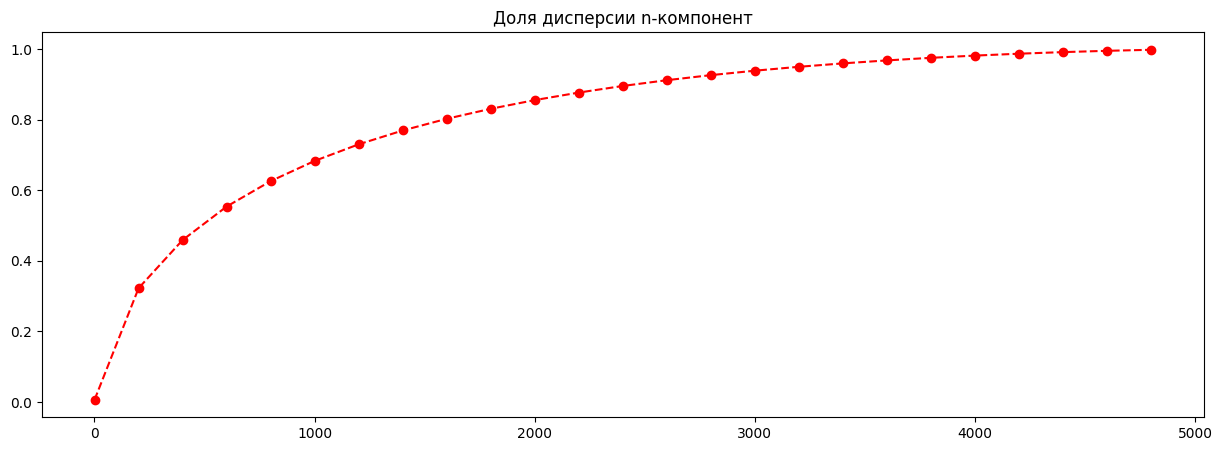

In [26]:
performance = []
test = range(1, MAX_WORDS, 200)

for n in tqdm_notebook(test):
    svd = TruncatedSVD(n_components=n)
    lsa = svd.fit(tfidf_array)
    performance.append(lsa.explained_variance_ratio_.sum())

fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('Доля дисперсии n-компонент');

**LSA + LogisticRegression**

In [195]:
y_pred, pred_proba, y_pred_tr = make_classification(  \
      
      TfIdfSVDTransformer(svd_n_components=300),
      LogisticRegression(class_weight='balanced', 
                         random_state=RAND),
      X_train,
      y_train,
      X_test

)


metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'LSA LogisticRegression test')
    
                    ])

metrics.set_index('model')

f1_score train: 0.906
f1_score test: 0.899
delta = 0.9 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115


Метрики на тестовых данных чуть хуже чем с TF-IDF без снижения размерности, однако модель стала еще меньше переобучаться, что логично, снижение размерности - один из способов борьбы с переобучением.

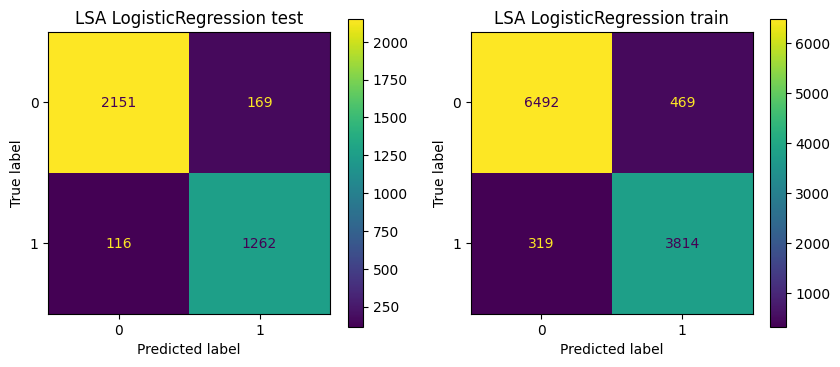

In [42]:
plot_confusion_matrices(y_train, 
                        y_test, 
                        y_pred, 
                        y_pred_tr,
                        'LSA LogisticRegression')

**LSA + LGBMClassifier**

In [196]:
y_pred, pred_proba, y_pred_tr = make_classification(    \

    TfIdfSVDTransformer(svd_n_components=300),
    LGBMClassifier(class_weight='balanced',
                   random_state=RAND,
                   verbose=0),
    X_train_,
    y_train_,
    X_test,
    X_val,
    y_val

)

metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'LSA LGBM test')
    
                    ])

metrics.set_index('model')

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's binary_logloss: 0.240046
f1_score train: 0.992
f1_score test: 0.890
delta = 11.4 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944


Бейзлайн LightGBM с LSA переобучается сильнее чем с TF-IDF

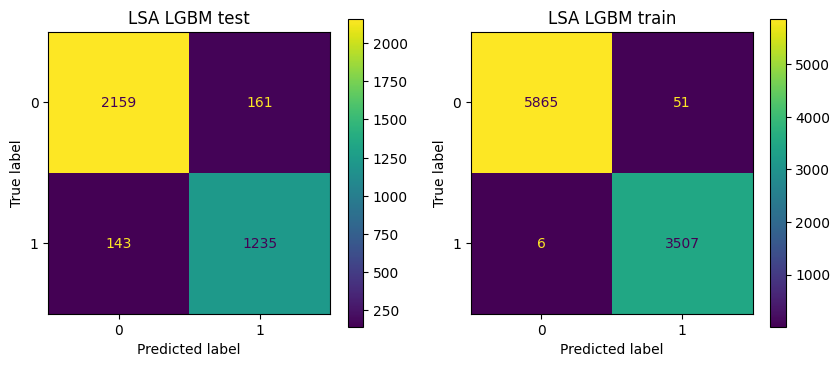

In [44]:
plot_confusion_matrices(y_train_, 
                        y_test, 
                        y_pred, 
                        y_pred_tr,
                        'LSA LGBM')

**LSA + CatBoost**

In [197]:
y_pred, pred_proba, y_pred_tr = make_classification(  \
    
    TfIdfSVDTransformer(svd_n_components=300),
    CatBoostClassifier(scale_pos_weight=ratio,
                       random_state=RAND,
                       eval_metric="F1"),
    X_train_,
    y_train_,
    X_test,
    X_val,
    y_val

)


metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'LSA CatBoost test')
    
                    ])

metrics.set_index('model')

f1_score train: 0.909
f1_score test: 0.889
delta = 2.3 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944


А вот CatBoost стал чуть более устойчив переобучению после применения LSA, снижение размерности не оказало
негативного влияния на качество модели

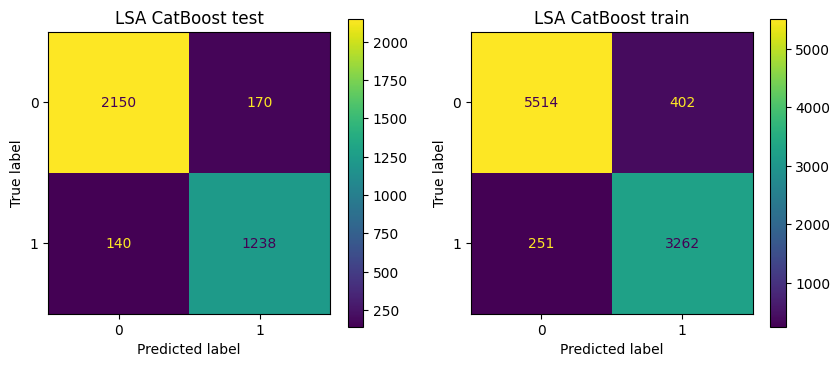

In [198]:
plot_confusion_matrices(y_train_, 
                        y_test, 
                        y_pred, 
                        y_pred_tr, 
                        'LSA CatBoost')

Метрики на тестовых данных

In [199]:
metrics.reset_index(drop=True)   \
    .style.highlight_max(color='lightblue')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
1,BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
2,TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
3,TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
4,TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
5,TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
6,TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
7,LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
8,LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944
9,LSA CatBoost test,0.916171,0.962901,0.879261,0.898403,0.888729,0.234304


Формально лучший результат на тестовых данных без учета устойчивости модели показала логистическая регрессия

## Word2Vec


Word2Vec - это метод векторного представления слов, разработанный для обучения нейронных сетей глубокого обучения на больших текстовых корпусах. Он преобразует каждое слово в непрерывный вектор фиксированной длины в многомерном пространстве, таким образом, что семантически близкие слова имеют близкие векторные представления. Метод обучается на основе контекста слова в предложениях, что позволяет улавливать семантические связи между ними.

В качестве исходных данных для эмбеддингов Word2Vec возьмем токены со стоп-словами, они могут помочь сохранить смыслы слов.


In [6]:
# Разбиение данных в таком же соотношении как и для предыдущих моделей
X = np.array(df.Tokens_stop)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.2, 
                                                    stratify=y_train, 
                                                    random_state=RAND)

Сначала создадим модель Word2Vec, обученную только на корпусе слов из отзывов

In [203]:
# Корпус всех документов
corpus = df.Tokens_stop.tolist()

# Cоздание модель Word2Vec
model = gensim.models.Word2Vec([doc.split() for doc in corpus], 
                               vector_size=100, window=5, workers=4)

Отобразим эмбеддинги векторов слов из словаря Word2Vec на двухмерной плоскости. Для этого возьмем несколько слов, которые
часто будут встречаться в отзывах и посмотрим на топ-30 ближайших (на основании косинусного расстояния) слов к каждому из слов списка.

In [205]:
# Список слов
key_words = ['озон', 'отказ', 'покупка', 'маркет', 'мошенник', 'радость']

In [206]:
# Создание пустых списков для кластеров эмбеддингов и соответствующих слов

embedding_clusters = []
word_clusters = []

for word in key_words:
    
    # Создание пустых списков для текущего кластера
    embeddings = []
    words = []
    
    # Получение наиболее похожих слов для текущего ключевого слова
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
        
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
#Преобразование списка кластеров эмбеддингов в массив    
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

# Создание модели t-SNE и вычисление двумерных представлений эмбеддингов
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', 
                        n_iter=3500, random_state=RAND)

embeddings_en_2d = np.array(tsne_model_en_2d   \
                       .fit_transform(
                           embedding_clusters.reshape(n * m, k))
                                      ).reshape(n, m, 2)

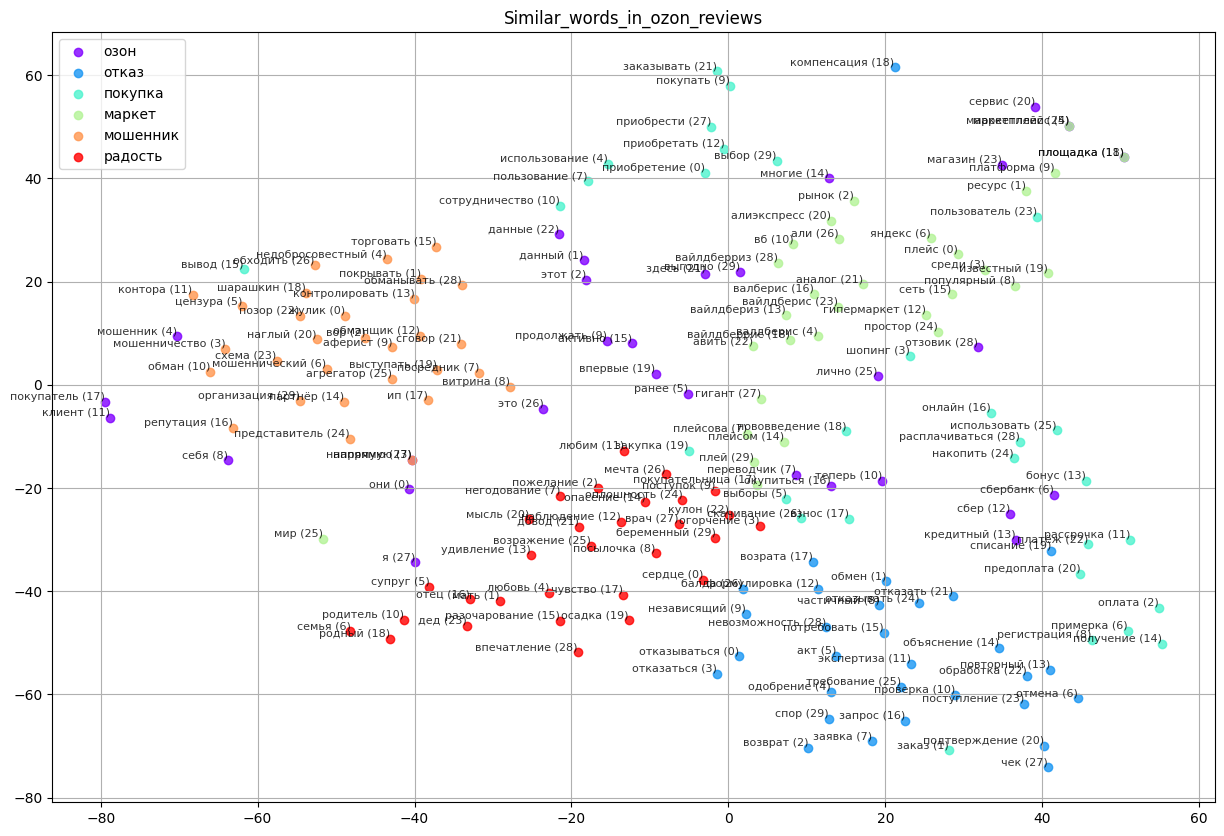

In [207]:
tsne_plot_similar_words('Similar_words_in_ozon_reviews', 
                        labels=key_words,
                        embedding_clusters=embeddings_en_2d,
                        word_clusters=word_clusters,
                        alpha=.8,
                        filename='similar_words.png' ,
                        font_size=8)

**Word2Vec + LogisticRegression**

In [208]:
y_pred, pred_proba, y_pred_tr = make_classification(   \

    mean_vectorizer(model.wv),
    LogisticRegression(class_weight='balanced',
                       random_state=RAND),
    X_train,
    y_train,
    X_test

)

metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'W2V LogisticRegression test')
    
                    ])

metrics.set_index('model')

f1_score train: 0.894
f1_score test: 0.893
delta = 0.0 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944


**Word2Vec + CatBoost**

In [209]:
y_pred, pred_proba, y_pred_tr = make_classification(   \
                                                    
    mean_vectorizer(model.wv),
    CatBoostClassifier(scale_pos_weight=ratio,
                       random_state=RAND,
                       eval_metric="F1"),
    X_train_,
    y_train_,
    X_test,
    X_val,
    y_val

)

metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'W2V Catboost test')
    
                    ])

metrics.set_index('model')

f1_score train: 0.919
f1_score test: 0.889
delta = 3.4 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944


In [57]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

Попробуем взять предобученные вектора Word2Vec и дообучить на нашем корпусе 

In [59]:
pretrained_vectors = gensim.downloader.load('word2vec-ruscorpora-300')

In [19]:
# Создание словаря vocab, где ключи - слова из pretrained_vectors без индекса,
# а значения - соответствующие векторы слов
vocab = {word.split('_')[0]: pretrained_vectors[word] 
             for word in pretrained_vectors.index_to_key}

# Создание экземпляра модели Word2Vec с указанным размером вектора и минимальным 
# количеством вхождений слова
model = Word2Vec(vector_size=pretrained_vectors.vector_size, 
                 min_count=1)

# Построение словаря модели Word2Vec из vocab с минимальным количеством вхождений равным 1,
# без обновления словаря модели
model.build_vocab_from_freq({word: 1 for word in vocab.keys()},
                            update=False)

# Создание списков ключей и значений из словаря vocab
voc_keys = list(vocab.keys())
voc_values = list(vocab.values())
# Добавление векторов слов в словарь модели Word2Vec
model.wv.add_vectors(voc_keys, voc_values)



In [20]:
# Тренировка предобученной модели на корпусе отзывов
model.train([doc.split() for doc in corpus], 
            total_examples=len(corpus), epochs=20)

KeyboardInterrupt: 

In [43]:
# model.wv.save_word2vec_format('w2v_pretrained.bin', binary=True)

In [210]:
# Загрузка дообученных на корпусе отзывов векторов
vocab = gensim.models.KeyedVectors    \
    .load_word2vec_format('w2v_pretrained.bin', binary=True)

**Pretrained Word2Vec + LogisticRegression**

In [212]:
y_pred, pred_proba, y_pred_tr = make_classification(   \
                                                    
    mean_vectorizer(vocab),
    LogisticRegression(class_weight='balanced',
                       random_state=RAND),
    X_train,
    y_train,
    X_test
                                             
)

metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'Pretrain W2V LogisticRegression test')
    
                    ])


metrics.set_index('model')

f1_score train: 0.850
f1_score test: 0.854
delta = 0.4 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944


**Pretrained Word2Vec + LGBMClassifier**

In [213]:
y_pred, pred_proba, y_pred_tr = make_classification(   \
                                                    
    mean_vectorizer(vocab),
    LGBMClassifier(class_weight='balanced',
                   random_state=RAND,
                   verbose=0),
    X_train_,
    y_train_,
    X_test,
    X_val,
    y_val
                                                    
)

metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'Pretrain W2V LGBM test')
    
                    ])

metrics.set_index('model')

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's binary_logloss: 0.309151
f1_score train: 0.915
f1_score test: 0.856
delta = 6.8 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944


**Pretrained Word2Vec + CatBoost**

In [214]:
y_pred, pred_proba, y_pred_tr = make_classification(  \
                                                    
    mean_vectorizer(vocab),
    CatBoostClassifier(scale_pos_weight=ratio,
                       random_state=RAND,
                       eval_metric="F1"),
    X_train_,
    y_train_,
    X_test,
    X_val,
    y_val
                  
)

metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              y_pred, 
                              pred_proba, 
                              'Pretrain W2V CatBoost test')
    
                    ])
metrics.set_index('model')

f1_score train: 0.870
f1_score test: 0.858
delta = 1.4 %


,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944


Модель Word2Vec, обученная исключительно на корпусе отзывов справилась лучше, чем предобученная модель
Wor2Vec, дообученная на корпусе отзывов. Возможной причиной является контекст и специфический язык отзывов, сильно отличающийся от языка текстов, на которых модель была предобучена.

Так же стоит отметить, что при представлении текстов векторами Word2Vec все классификаторы оказались устойчивы к переобучению, хоть и показали метрики хуже по сравнению со статистическами методами представления текста

In [215]:
metrics.reset_index(drop=True)   \
    .style.highlight_max(color='lightblue')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
1,BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
2,TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
3,TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
4,TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
5,TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
6,TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
7,LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
8,LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944
9,LSA CatBoost test,0.916171,0.962901,0.879261,0.898403,0.888729,0.234304


## BERT

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [9]:
# Предобученный токенизатор
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/distilrubert-tiny-cased-conversational")

batch_size = 8
max_length = 512

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [10]:
def tokenize_function(tokenizer, 
                      data: List[str], 
                      max_length: int = max_length) -> dict:
    """
    Токенизирует текстовые данные с использованием заданного токенизатора.

    Параметры:
    tokenizer: Объект токенизатора для токенизации текста.
    data: Список текстовых данных для токенизации.
    max_length: Максимальная длина последовательности токенов.
    
    Возвращает:
    Dict: Словарь с тензорами 'input_ids' и 'attention_mask'.
    """
        
    input_ids = []
    attention_masks = []
    
    for rev in data:
        encoded_dict = tokenizer.encode_plus(rev, 
                                         add_special_tokens=True, 
                                         max_length=max_length,
                                         pad_to_max_length=True,
                                         truncation=True,
                                         return_attention_mask=True,
                                         return_tensors='pt')
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])


    input_ids = torch.cat(input_ids)
    attention_masks = torch.cat(attention_masks)
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
           }


# def compute_metrics(eval_preds):
#     """Расчет F1-меры"""
    
#     metric = load_metric("f1")
#     logits, labels = eval_preds
#     predictions = np.argmax(logits, axis=-1)
#     f1 = f1_score(labels, predictions, average='binary')
    
#     return {"f1": f1}


def compute_metrics(eval_preds):
    """Расчет метрики roc-auc"""

    metric = evaluate.load("roc_auc")
    logits, labels = eval_preds
    predictions = softmax(logits)[:, 1]
    res = metric.compute(prediction_scores=predictions, 
                         references=labels)

    return {'roc_auc': res['roc_auc']}

In [11]:
class GroupsDataset(torch.utils.data.Dataset):
    """
    Пользовательский класс датасета предоставляющий 
    доступ по индексу для использования с  объектом класса Trainer из библиотеки transformers.

    Параметры:
    encodings: Словарь с закодированными данными.
    labels: Список меток для каждого элемента данных.
    """
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}

        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)
    

In [12]:
# Токенизация данных

train_encodings = tokenize_function(tokenizer, 
                                    X_train_.tolist())
val_encodings = tokenize_function(tokenizer, 
                                  X_val.tolist())
test_encodings = tokenize_function(tokenizer, 
                                   X_test.tolist())

# Создание объектов пользовательского класса GroupsDataset, хранящего
# токенизированные данные, метки классов и предоставляющий доступ к элементам
# по индексам 

train_dataset = GroupsDataset(train_encodings, 
                              y_train_.tolist())
eval_dataset = GroupsDataset(val_encodings, 
                             y_val.tolist())
test_dataset = GroupsDataset(test_encodings, 
                             y_test.tolist())

In [14]:
# Предобученная модель классификации 

model = BertForSequenceClassification  \
    .from_pretrained('DeepPavlov/distilrubert-tiny-cased-conversational', num_labels=2)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/428M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'enc

In [15]:
# Заморозка параметров 

for param in model.bert.parameters():
    param.requires_grad = False

# Перенос вычислений модель на GPU
model.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [18]:
# Параметры для обучения 

args = TrainingArguments("bert_tiny2",
                         evaluation_strategy="epoch",
                         save_strategy="no",
                         learning_rate=2e-5,
                         num_train_epochs=5,
                         weight_decay=0.01,
                         push_to_hub=False,
                         per_device_train_batch_size=64,
                         logging_steps=200)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss


In [88]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

In [ ]:
for param in model.bert.parameters():
    param.requires_grad = True

In [80]:
args = TrainingArguments("bert_tiny2",
                         evaluation_strategy="epoch",
                         save_strategy="no",
                         learning_rate=2e-5,
                         num_train_epochs=10,
                         weight_decay=0.01,
                         push_to_hub=False,
                         per_device_train_batch_size=64,
                         logging_steps=200)

In [81]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,No log,0.376094,0.932261
2,0.462800,0.291379,0.943307
3,0.274800,0.277403,0.948210
4,0.274800,0.270038,0.951018
5,0.248800,0.266905,0.952403
6,0.237000,0.265226,0.953571
7,0.237000,0.264372,0.954066
8,0.232600,0.262701,0.954281
9,0.230800,0.262443,0.954645
10,0.230800,0.262336,0.954696


TrainOutput(global_step=1390, training_loss=0.27428310860832816, metrics={'train_runtime': 324.3806, 'train_samples_per_second': 273.598, 'train_steps_per_second': 4.285, 'total_flos': 654460869120000.0, 'train_loss': 0.27428310860832816, 'epoch': 10.0})

Loss на валидационных данных после пятой итерации начинает расти, а на обучающих продолжает снижаться,
модель начинает переобучаться.

In [279]:
# trainer.save_model('bert_tiny2')

In [84]:
model = BertForSequenceClassification    \
                                .from_pretrained("bert_tiny2")

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [85]:
# Предсказание модели классификации Bert
y_pred = trainer.predict(test_dataset)

# Получение вероятностей
pred_proba = y_pred[0]

# Получение предсказанных меток класса
pred = pred_proba.argmax(axis=1)

In [225]:
metrics = pd.concat([
    
   metrics, 
   get_metrics_classification(y_test, 
                              pred, 
                              pred_proba, 
                              'Bert_tiny2')
                    ])


metrics.reset_index(drop=True)   \
    .style.highlight_max(color='lightblue')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,BOW NaiveBayes test,0.886425,0.952092,0.802399,0.922351,0.858204,1.169440
1,BOW Logistic_regression test,0.909681,0.956329,0.873391,0.886067,0.879683,0.311250
2,TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
3,TF-IDF LogisticRegression test,0.927258,0.969086,0.895225,0.911466,0.903272,0.225950
4,TF-IDF RandomForest test,0.915630,0.960143,0.897168,0.873730,0.885294,0.294521
5,TF-IDF LGBM test,0.919145,0.963688,0.880734,0.905660,0.893023,0.228233
6,TF-IDF CatBoost test,0.913196,0.962213,0.874027,0.896226,0.884987,0.254549
7,LSA LogisticRegression test,0.922931,0.969774,0.881901,0.915820,0.898540,0.213115
8,LSA LGBM test,0.917793,0.965186,0.884670,0.896226,0.890411,0.222944
9,LSA CatBoost test,0.916171,0.962901,0.879261,0.898403,0.888729,0.234304


Bert удалось улучшить метрики (я решил использовать эту модель, так как она намного быстрее чем DeepPavlov, хотя там метрики немного лучше получались). 

- Большинство использованных бейзлайнов моделей очень хорошо справились с классификацией.
- Снижение размерности положительно сказалось на работе большинства моделей: увеличилась устойчивость (за исключением 
LightGBM), метрики на тестовых данных оказались на уровне TF-IDF)
- Использование текстового представления Word2Vec с применением классических моделей не позволило улучшить метрики на 
тестовых данных, однако положительно сказалось на устойчивости.

Визуализации вклада слов/словосочетаний в тональность отзыва

In [240]:
pipe = TextClassificationPipeline(model=model, 
                                  tokenizer=tokenizer, 
                                  return_all_scores=True)

In [241]:
def score_and_visualize(text: str):
    """
    Оценивает и визуализирует предсказания модели для входного текста с помощью
    библиотеки shap.

    Параметры:
    text: Входной текст для оценки и визуализации.
    """
    prediction = pipe([text])
    print(prediction[0])

    explainer = shap.Explainer(pipe)
    shap_values = explainer([text])

    shap.plots.text(shap_values)

In [242]:
score_and_visualize(df.reviewText[60])

[{'label': 'LABEL_0', 'score': 0.8960933089256287}, {'label': 'LABEL_1', 'score': 0.10390675067901611}]



  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.14s/it]                                                                   
